In [72]:
from PIL import Image

import pandas as pd
import numpy as np
import json
from tqdm import tqdm
import time
from easydict import EasyDict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms

torch.manual_seed(1)

In [4]:
import os
colab = "/content/drive/Othercomputers/내 iMac/Meta_Learning/코스웍/2022 고급기계학습주제 (김광인)/과제/CW4/code"

In [24]:
img_train = []

for i in tqdm(range(1,3001)):
    ImagePATH = "data/Training/depth/"
    img_name = "depth_1_" + str(i).zfill(7) + ".png"
    ImagePATH = os.path.join(colab,ImagePATH + img_name)
    img_train.append(np.array(Image.open(ImagePATH), dtype=np.float32))

100%|██████████| 3000/3000 [19:42<00:00,  2.54it/s]


In [8]:
img_val = []

for i in tqdm(range(3001,3151)):
    ImagePATH = "data/Training/depth/"
    img_name = "depth_1_" + str(i).zfill(7) + ".png"
    ImagePATH = os.path.join(colab, ImagePATH + img_name)
    img_val.append(np.array(Image.open(ImagePATH), dtype=np.float32))

100%|██████████| 150/150 [01:11<00:00,  2.09it/s]


In [25]:
img_test = []

for i in tqdm(range(1,301)):
    ImagePATH = "data/Testing/depth/"
    img_name = "depth_1_" + str(i).zfill(7) + ".png"
    ImagePATH = os.path.join(colab, ImagePATH + img_name)
    img_test.append(np.array(Image.open(ImagePATH), dtype=np.float32))

100%|██████████| 300/300 [02:34<00:00,  1.95it/s]


In [26]:
X_train = np.array(img_train, dtype=np.float32)
X_val = np.array(img_val, dtype=np.float32)
X_test = np.array(img_test, dtype=np.float32)

mean=1881.42
std=12.29

# Standardise
X_train -= mean
X_train /= std
X_val -= mean
X_val /= std
X_test -= mean
X_test /= std

np.save(os.path.join(colab, "data/X_train"),X_train)
np.save(os.path.join(colab, "data/X_val"),X_val)
np.save(os.path.join(colab, "data/X_test"),X_test)

print("train image dim:", X_train.shape)
print("val image dim:", X_val.shape)
print("test image dim:", X_test.shape)

train image dim: (3000, 240, 320)
val image dim: (150, 240, 320)
test image dim: (300, 240, 320)


In [27]:
whole_y_train = pd.read_csv(os.path.join(colab,"data/Training/Annotation_Training.csv"),
                            usecols = [i for i in range(1,64)],
                            skiprows = [1,2,3])
whole_y_test = pd.read_csv(os.path.join(colab,"data/Testing/Annotation_Testing.csv"),
                      usecols = [i for i in range(1,64)],
                      skiprows = [1,2,3])

whole_y_train.set_axis([i for i in range(63)], axis=1, inplace=True)
whole_y_test.set_axis([i for i in range(63)], axis=1, inplace=True)

y_train = whole_y_train[:3000]
y_val = whole_y_train[3000:3150]
y_test = whole_y_test[:300]

## Parameters

In [30]:
batch_size = 32
mlp_hidden_size = 77
lr = 0.1
n_epochs = 10

## Tensor Dataset

In [35]:
def make_loader(X, y, bs):
    """X, y: ndarray"""
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y.values, dtype=torch.float32)
    ds = TensorDataset(X, y)
    loader = DataLoader(ds, batch_size=bs, shuffle=True, drop_last=True)
    return loader

In [38]:
train_loader = make_loader(X_train, y_train, batch_size)
val_loader = make_loader(X_val, y_val, batch_size)
test_loader = make_loader(X_test, y_test, batch_size)

In [39]:
# check
for img, label in train_loader:
  print(img.shape)
  print(label.shape)
  break

torch.Size([32, 240, 320])
torch.Size([32, 63])


# 3.MLP

In [40]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [41]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=63, dropout=nn.Dropout(0.5)):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.linear = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            self.dropout,
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            self.dropout,
            nn.Linear(hidden_size, output_size)
        )
    
    def forward(self, x):
        x = self.linear(x)
        return x

In [42]:
model = MLP(input_size=76800, hidden_size = mlp_hidden_size).to(device)
model

MLP(
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Sequential(
    (0): Linear(in_features=76800, out_features=77, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=77, out_features=77, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=77, out_features=63, bias=True)
  )
)

In [43]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [46]:
loss = {"train":[], "val":[], "test":[]}
best_mse = 9999999999
PATH = "/content/drive/Othercomputers/내 iMac/Meta_Learning/코스웍/2022 고급기계학습주제 (김광인)/과제/CW4/code/best_models"

# Train the model
start = time.time()

for epoch in range(n_epochs):
    running_train_loss = 0.0
    running_val_loss = 0.0

    model.train()
    for i, (images, labels) in enumerate(tqdm(train_loader)):  
        # origin shape: [32, 240, 320]
        # resized: [32, 76800]
        images = images.reshape(batch_size, -1).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        outputs = outputs.squeeze(1)
        train_loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        running_train_loss +=train_loss.item()

    train_loss_value = running_train_loss/len(train_loader)
    loss["train"].append(train_loss_value)

    if (i+1) % 1 == 0:
        print (f'Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_loss_value:.4f}')

    # Validation loop
    with torch.no_grad():
        model.eval()
        for images, labels in val_loader:
            images = images.reshape(batch_size, 1, -1).to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            outputs = outputs.squeeze(1)
            val_loss = criterion(outputs, labels)
            running_val_loss += val_loss.item()

        # Calculate validation loss value 
        val_loss_value = running_val_loss/len(val_loader) 
        loss["val"].append(val_loss_value)
        print (f'Epoch [{epoch+1}/{n_epochs}], Validation Loss: {val_loss_value:.4f}')
    
    # Save the model if MSE loss is the best
    if val_loss_value < best_mse:
        torch.save(model.state_dict(), os.path.join(PATH, f"MLP_hs{mlp_hidden_size}.pth"))
        best_mse = val_loss_value
        print("new best model! Epoch:", epoch+1, " Lr:", lr)
end = time.time()
print("Run time [s]: ",end-start)

import json
json.dumps(loss)

100%|██████████| 93/93 [00:08<00:00, 10.48it/s]


Epoch [1/10], Train Loss: 0.6811
Epoch [1/10], Validation Loss: 0.6512
new best model! Epoch: 1  Lr: 0.1


100%|██████████| 93/93 [00:08<00:00, 10.62it/s]


Epoch [2/10], Train Loss: 0.6549
Epoch [2/10], Validation Loss: 0.6318
new best model! Epoch: 2  Lr: 0.1


100%|██████████| 93/93 [00:08<00:00, 10.57it/s]


Epoch [3/10], Train Loss: 0.6185
Epoch [3/10], Validation Loss: 0.6103
new best model! Epoch: 3  Lr: 0.1


100%|██████████| 93/93 [00:08<00:00, 10.60it/s]


Epoch [4/10], Train Loss: 0.5924
Epoch [4/10], Validation Loss: 0.5871
new best model! Epoch: 4  Lr: 0.1


100%|██████████| 93/93 [00:08<00:00, 10.63it/s]


Epoch [5/10], Train Loss: 0.5691
Epoch [5/10], Validation Loss: 0.5628
new best model! Epoch: 5  Lr: 0.1


100%|██████████| 93/93 [00:15<00:00,  5.98it/s]


Epoch [6/10], Train Loss: 0.5436
Epoch [6/10], Validation Loss: 0.5380
new best model! Epoch: 6  Lr: 0.1


100%|██████████| 93/93 [00:19<00:00,  4.73it/s]


Epoch [7/10], Train Loss: 0.5169
Epoch [7/10], Validation Loss: 0.5121
new best model! Epoch: 7  Lr: 0.1


100%|██████████| 93/93 [00:17<00:00,  5.36it/s]


Epoch [8/10], Train Loss: 0.4932
Epoch [8/10], Validation Loss: 0.4867
new best model! Epoch: 8  Lr: 0.1


100%|██████████| 93/93 [00:16<00:00,  5.65it/s]


Epoch [9/10], Train Loss: 0.4680
Epoch [9/10], Validation Loss: 0.4606
new best model! Epoch: 9  Lr: 0.1


100%|██████████| 93/93 [00:16<00:00,  5.68it/s]


Epoch [10/10], Train Loss: 0.4424
Epoch [10/10], Validation Loss: 0.4351
new best model! Epoch: 10  Lr: 0.1
Run time [s]:  130.98547840118408


'{"train": [0.6810867087815398, 0.6549177253118126, 0.6185270829867291, 0.5924347536538237, 0.5690698142974607, 0.5435593403795714, 0.5169278780619303, 0.4931814004016179, 0.46796243133083465, 0.4423946103742046], "val": [0.6511548757553101, 0.6318150162696838, 0.6102837324142456, 0.5870993584394455, 0.5628125071525574, 0.5380411595106125, 0.5121318697929382, 0.4867373928427696, 0.46061599999666214, 0.4350716546177864], "test": []}'

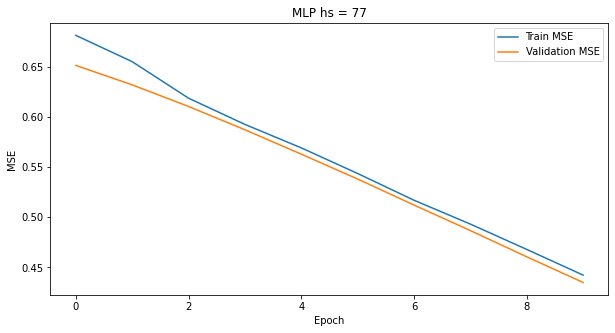

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(loss["train"], label='Train MSE')
plt.plot(loss["val"], label='Validation MSE')

plt.title(f"MLP hs = {mlp_hidden_size}")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

In [55]:
# Test loop
# Load the model that we saved at the end of the training loop
# model = MLP(76800, mlp_hidden_size).to(device)
# path = f"MLP_hs{mlp_hidden_size}.pth" 
# model.load_state_dict(torch.load(path)) 
  
running_test_mse = 0.0

with torch.no_grad(): 
    for images, labels in tqdm(test_loader):
        images = images.reshape(batch_size, -1).to(device)
        labels = labels.to(device) 
  
        outputs = model(images)
        outputs = outputs.squeeze(1)

        test_mse = F.mse_loss(outputs, labels)
        running_test_mse += test_mse.item()
        
    # Calculate test loss value 
    test_loss_value = running_test_mse/len(test_loader) 
    loss["test"].append(test_loss_value)
    print (f'Test MSE: {test_loss_value:.4f}')

100%|██████████| 9/9 [00:00<00:00, 52.25it/s]

Test MSE: 0.4700


# MLP automation

In [121]:
def train(batch_size, mlp_hidden_size, lr, n_epochs):
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Model
    model = MLP(76800, mlp_hidden_size).to(device)
    
    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Loop preparation
    loss = {"train":[], "val":[], "test":[]}
    best_mse = 9999999999
    PATH = "/content/drive/Othercomputers/내 iMac/Meta_Learning/코스웍/2022 고급기계학습주제 (김광인)/과제/CW4/code/best_models"

    # Train the model
    print("Train starts!")
    start = time.time()

    for epoch in range(n_epochs):
        running_train_loss = 0.0
        running_val_loss = 0.0

        model.train()
        for i, (images, labels) in enumerate(tqdm(train_loader)):  
            # origin shape: [32, 240, 320]
            # resized: [32, 76800]
            images = images.reshape(batch_size, -1).to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            outputs = outputs.squeeze(1)
            train_loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            running_train_loss +=train_loss.item()

        train_loss_value = running_train_loss/len(train_loader)
        loss["train"].append(train_loss_value)

        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_loss_value:.4f}')

        # Validation loop
        with torch.no_grad():
            model.eval()
            for images, labels in val_loader:
                images = images.reshape(batch_size, 1, -1).to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                outputs = outputs.squeeze(1)
                val_loss = criterion(outputs, labels)
                running_val_loss += val_loss.item()

            # Calculate validation loss value 
            val_loss_value = running_val_loss/len(val_loader) 
            loss["val"].append(val_loss_value)
            if (epoch+1) % 5 == 0:
                print(f'Epoch [{epoch+1}/{n_epochs}], Validation Loss: {val_loss_value:.4f}')
        
        # Save the model if MSE loss is the best
        if val_loss_value < best_mse:
            torch.save(model.state_dict(), os.path.join(PATH, f"MLP_hs{mlp_hidden_size}_lr{lr}.pth"))
            best_mse = val_loss_value
            # print("new best model! Epoch:", epoch+1, " Lr:", lr)
    end = time.time()
    print("Run time [s]: ",end-start)
    
    json.dumps(loss)

    return loss, model

In [108]:
def test(loss, mlp_hidden_size, lr, batch_size=32):
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load the model that we saved at the end of the training loop
    model = MLP(76800, mlp_hidden_size).to(device)
    PATH = "/content/drive/Othercomputers/내 iMac/Meta_Learning/코스웍/2022 고급기계학습주제 (김광인)/과제/CW4/code/best_models"
    path = os.path.join(PATH, f"MLP_hs{mlp_hidden_size}_lr{lr}.pth")
    model.load_state_dict(torch.load(path)) 
    running_test_mse = 0.0

    print("Test starts!")
    with torch.no_grad(): 
        for images, labels in tqdm(test_loader):
            images = images.reshape(batch_size, -1).to(device)
            labels = labels.to(device) 
      
            outputs = model(images)
            outputs = outputs.squeeze(1)

            test_mse = F.mse_loss(outputs, labels)
            running_test_mse += test_mse.item()
            
        # Calculate test loss value 
        test_loss_value = running_test_mse/len(test_loader) 
        loss["test"].append(test_loss_value)
        print (f'Test MSE: {test_loss_value:.4f}')
    return loss

In [78]:
args = EasyDict({
    "batch_size": 32,
    "mlp_hidden_size": 77,
    "lr": 0.1,
    "n_epochs": 30,
})

Train starts!


100%|██████████| 93/93 [00:10<00:00,  8.47it/s]


Epoch [1/30], Train Loss: 15074530.3812
Epoch [1/30], Validation Loss: 0.2540
new best model! Epoch: 1  Lr: 0.1


100%|██████████| 93/93 [00:09<00:00,  9.56it/s]


Epoch [2/30], Train Loss: 2511.1502
Epoch [2/30], Validation Loss: 0.2534
new best model! Epoch: 2  Lr: 0.1


100%|██████████| 93/93 [00:09<00:00,  9.61it/s]


Epoch [3/30], Train Loss: 0.2374
Epoch [3/30], Validation Loss: 0.2499
new best model! Epoch: 3  Lr: 0.1


100%|██████████| 93/93 [00:09<00:00,  9.68it/s]


Epoch [4/30], Train Loss: 0.2333
Epoch [4/30], Validation Loss: 0.2458
new best model! Epoch: 4  Lr: 0.1


100%|██████████| 93/93 [00:09<00:00,  9.47it/s]


Epoch [5/30], Train Loss: 0.2283
Epoch [5/30], Validation Loss: 0.2412
new best model! Epoch: 5  Lr: 0.1


100%|██████████| 93/93 [00:09<00:00,  9.47it/s]


Epoch [6/30], Train Loss: 551.2418
Epoch [6/30], Validation Loss: 0.2347
new best model! Epoch: 6  Lr: 0.1


100%|██████████| 93/93 [00:09<00:00,  9.62it/s]


Epoch [7/30], Train Loss: 0.2169
Epoch [7/30], Validation Loss: 0.2293
new best model! Epoch: 7  Lr: 0.1


100%|██████████| 93/93 [00:09<00:00,  9.64it/s]


Epoch [8/30], Train Loss: 0.2117
Epoch [8/30], Validation Loss: 0.2237
new best model! Epoch: 8  Lr: 0.1


100%|██████████| 93/93 [00:14<00:00,  6.21it/s]


Epoch [9/30], Train Loss: 0.2059
Epoch [9/30], Validation Loss: 0.2179
new best model! Epoch: 9  Lr: 0.1


100%|██████████| 93/93 [00:20<00:00,  4.47it/s]


Epoch [10/30], Train Loss: 0.2004
Epoch [10/30], Validation Loss: 0.2119
new best model! Epoch: 10  Lr: 0.1


100%|██████████| 93/93 [00:18<00:00,  5.03it/s]


Epoch [11/30], Train Loss: 0.1940
Epoch [11/30], Validation Loss: 0.2058
new best model! Epoch: 11  Lr: 0.1


100%|██████████| 93/93 [00:17<00:00,  5.46it/s]


Epoch [12/30], Train Loss: 0.1879
Epoch [12/30], Validation Loss: 0.1994
new best model! Epoch: 12  Lr: 0.1


100%|██████████| 93/93 [00:16<00:00,  5.52it/s]


Epoch [13/30], Train Loss: 0.1818
Epoch [13/30], Validation Loss: 0.1931
new best model! Epoch: 13  Lr: 0.1


100%|██████████| 93/93 [00:16<00:00,  5.50it/s]


Epoch [14/30], Train Loss: 0.1749
Epoch [14/30], Validation Loss: 0.1867
new best model! Epoch: 14  Lr: 0.1


100%|██████████| 93/93 [00:16<00:00,  5.52it/s]


Epoch [15/30], Train Loss: 0.1695
Epoch [15/30], Validation Loss: 0.1802
new best model! Epoch: 15  Lr: 0.1


100%|██████████| 93/93 [00:17<00:00,  5.27it/s]


Epoch [16/30], Train Loss: 0.1628
Epoch [16/30], Validation Loss: 0.1738
new best model! Epoch: 16  Lr: 0.1


100%|██████████| 93/93 [00:17<00:00,  5.43it/s]


Epoch [17/30], Train Loss: 0.1569
Epoch [17/30], Validation Loss: 0.1673
new best model! Epoch: 17  Lr: 0.1


100%|██████████| 93/93 [00:18<00:00,  4.94it/s]


Epoch [18/30], Train Loss: 0.1503
Epoch [18/30], Validation Loss: 0.1608
new best model! Epoch: 18  Lr: 0.1


100%|██████████| 93/93 [00:18<00:00,  5.00it/s]


Epoch [19/30], Train Loss: 0.1442
Epoch [19/30], Validation Loss: 0.1544
new best model! Epoch: 19  Lr: 0.1


100%|██████████| 93/93 [00:19<00:00,  4.87it/s]


Epoch [20/30], Train Loss: 0.1381
Epoch [20/30], Validation Loss: 0.1481
new best model! Epoch: 20  Lr: 0.1


100%|██████████| 93/93 [00:19<00:00,  4.86it/s]


Epoch [21/30], Train Loss: 0.1316
Epoch [21/30], Validation Loss: 0.1417
new best model! Epoch: 21  Lr: 0.1


100%|██████████| 93/93 [00:17<00:00,  5.25it/s]


Epoch [22/30], Train Loss: 0.1255
Epoch [22/30], Validation Loss: 0.1355
new best model! Epoch: 22  Lr: 0.1


100%|██████████| 93/93 [00:16<00:00,  5.52it/s]


Epoch [23/30], Train Loss: 0.1197
Epoch [23/30], Validation Loss: 0.1293
new best model! Epoch: 23  Lr: 0.1


100%|██████████| 93/93 [00:16<00:00,  5.53it/s]


Epoch [24/30], Train Loss: 0.1140
Epoch [24/30], Validation Loss: 0.1232
new best model! Epoch: 24  Lr: 0.1


100%|██████████| 93/93 [00:16<00:00,  5.49it/s]


Epoch [25/30], Train Loss: 0.1082
Epoch [25/30], Validation Loss: 0.1171
new best model! Epoch: 25  Lr: 0.1


100%|██████████| 93/93 [00:16<00:00,  5.54it/s]


Epoch [26/30], Train Loss: 0.1027
Epoch [26/30], Validation Loss: 0.1112
new best model! Epoch: 26  Lr: 0.1


100%|██████████| 93/93 [00:16<00:00,  5.51it/s]


Epoch [27/30], Train Loss: 0.0973
Epoch [27/30], Validation Loss: 0.1054
new best model! Epoch: 27  Lr: 0.1


100%|██████████| 93/93 [00:16<00:00,  5.51it/s]


Epoch [28/30], Train Loss: 0.0917
Epoch [28/30], Validation Loss: 0.0997
new best model! Epoch: 28  Lr: 0.1


100%|██████████| 93/93 [00:16<00:00,  5.53it/s]


Epoch [29/30], Train Loss: 0.0864
Epoch [29/30], Validation Loss: 0.0941
new best model! Epoch: 29  Lr: 0.1


100%|██████████| 93/93 [00:16<00:00,  5.53it/s]


Epoch [30/30], Train Loss: 0.0812
Epoch [30/30], Validation Loss: 0.0886
new best model! Epoch: 30  Lr: 0.1
Run time [s]:  469.7052357196808
Test starts!


100%|██████████| 9/9 [00:00<00:00, 60.45it/s]

Test MSE: 0.1018


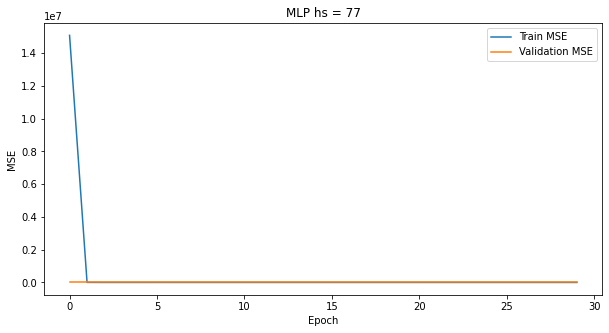

Test MSE [0.10183117455906338]


In [83]:
loss, _ = train(**args)
loss = test(loss, args["mlp_hidden_size"], args["lr"], args["batch_size"])

plt.figure(figsize=(10,5))
plt.plot(loss["train"], label='Train MSE')
plt.plot(loss["val"], label='Validation MSE')

plt.title(f"MLP hs = {mlp_hidden_size}")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

print("Test MSE", loss["test"])

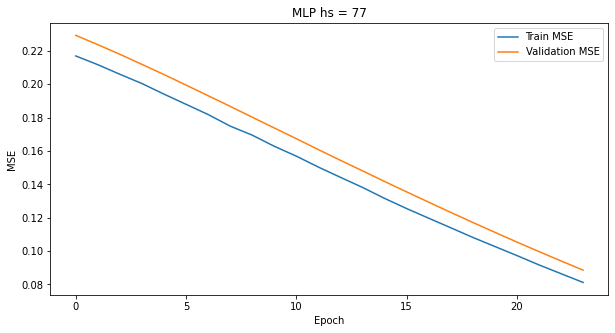

In [88]:
plt.figure(figsize=(10,5))
plt.plot(loss["train"][6:], label='Train MSE')
plt.plot(loss["val"][6:], label='Validation MSE')

plt.title(f"MLP hs = {mlp_hidden_size}")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

In [90]:
with open(os.path.join(colab, f"loss/MLPloss_hs{mlp_hidden_size}_lr{lr}.json"), 'w') as f:
    json.dump(loss, f)

Train starts!


100%|██████████| 93/93 [00:21<00:00,  4.34it/s]


Run time [s]:  548.4784414768219
Test starts!


100%|██████████| 9/9 [00:00<00:00, 69.90it/s]


Test MSE: 0.6885


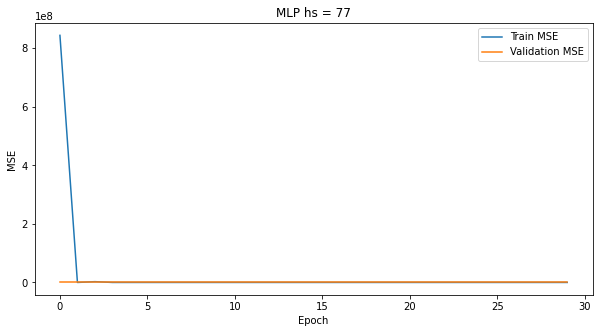

Test MSE [0.688547154267629]


In [98]:
args = EasyDict({
    "batch_size": 32,
    "mlp_hidden_size": 77,
    "lr": 0.2,
    "n_epochs": 30,
})

loss, _ = train(**args)
loss = test(loss, args["mlp_hidden_size"], args["lr"], args["batch_size"])

# Save
mlp_hidden_size = args["mlp_hidden_size"]
lr = args["lr"]
with open(os.path.join(colab, f"loss/MLPloss_hs{mlp_hidden_size}_lr{lr}.json"), 'w') as f:
    json.dump(loss, f)

plt.figure(figsize=(10,5))
plt.plot(loss["train"], label='Train MSE')
plt.plot(loss["val"], label='Validation MSE')

plt.title(f"MLP hs = {mlp_hidden_size}")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

print("Test MSE", loss["test"])

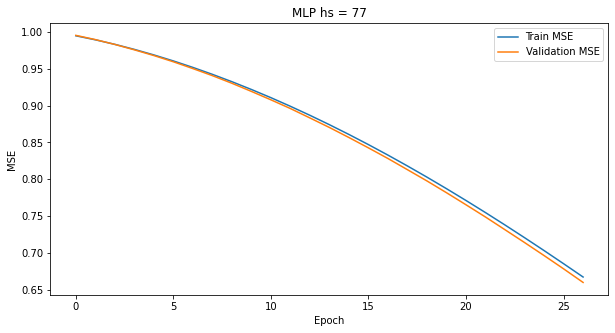

In [102]:
plt.figure(figsize=(10,5))
plt.plot(loss["train"][3:], label='Train MSE')
plt.plot(loss["val"][3:], label='Validation MSE')

plt.title(f"MLP hs = {mlp_hidden_size}")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

Train starts!


100%|██████████| 93/93 [00:21<00:00,  4.41it/s]


Run time [s]:  517.5711131095886
Test starts!


100%|██████████| 9/9 [00:00<00:00, 64.72it/s]


Test MSE: 18.5481


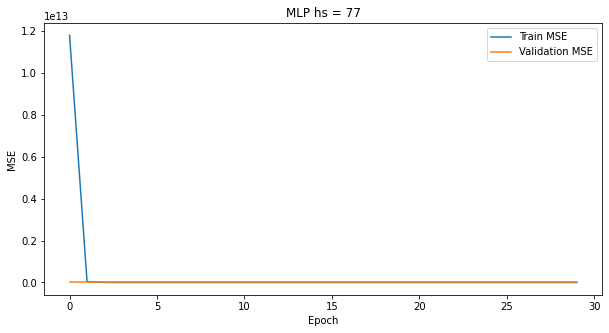

Test MSE [18.548056072658962]


In [109]:
args = EasyDict({
    "batch_size": 32,
    "mlp_hidden_size": 77,
    "lr": 1,
    "n_epochs": 30,
})

loss, _ = train(**args)
loss = test(loss, args["mlp_hidden_size"], args["lr"], args["batch_size"])

# Save
mlp_hidden_size = args["mlp_hidden_size"]
lr = args["lr"]
with open(os.path.join(colab, f"loss/MLPloss_hs{mlp_hidden_size}_lr{lr}.json"), 'w') as f:
    json.dump(loss, f)

plt.figure(figsize=(10,5))
plt.plot(loss["train"], label='Train MSE')
plt.plot(loss["val"], label='Validation MSE')

plt.title(f"MLP hs = {mlp_hidden_size}")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

print("Test MSE", loss["test"])

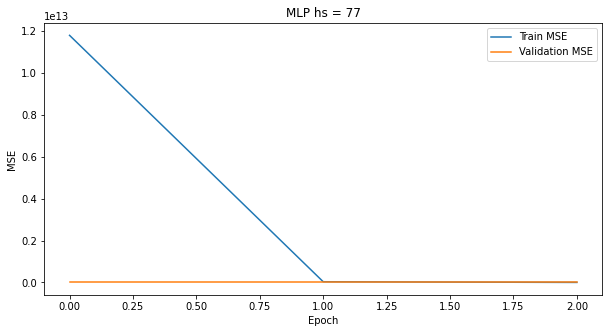

In [120]:
plt.figure(figsize=(10,5))
plt.plot(loss["train"][:3], label='Train MSE')
plt.plot(loss["val"][:3], label='Validation MSE')

plt.title(f"MLP hs = {mlp_hidden_size}")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

In [ ]:
args = EasyDict({
    "batch_size": 32,
    "mlp_hidden_size": 144,
    "lr": 0.2,
    "n_epochs": 30,
})

loss, _ = train(**args)
loss = test(loss, args["mlp_hidden_size"], args["lr"], args["batch_size"])

# Save
mlp_hidden_size = args["mlp_hidden_size"]
lr = args["lr"]
with open(os.path.join(colab, f"loss/MLPloss_hs{mlp_hidden_size}_lr{lr}.json"), 'w') as f:
    json.dump(loss, f)

plt.figure(figsize=(10,5))
plt.plot(loss["train"], label='Train MSE')
plt.plot(loss["val"], label='Validation MSE')

plt.title(f"MLP hs = {mlp_hidden_size}")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

print("Test MSE", loss["test"])

Train starts!


 32%|███▏      | 30/93 [00:05<00:10,  5.84it/s]

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(loss["train"][:3], label='Train MSE')
plt.plot(loss["val"][:3], label='Validation MSE')

plt.title(f"MLP hs = {mlp_hidden_size}")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()